In [1]:
import os
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

BASE_DIR = r"C:\Users\Keelan.Butler\Desktop\python_projects\Final Project"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
ROUTE_DIR = r"C:\Users\Keelan.Butler\Desktop\python_projects\Final Project"
DATA_DIR = os.path.join(ROUTE_DIR,"Sentry-AI","Python")
FEATURE_PATH = os.path.join(BASE_DIR,"Dataset","features")
os.chdir(DATA_DIR)
df_train, df_test = pd.read_csv('Train_set.csv'),pd.read_csv('Test_set.csv')
# load features 
df_train_new, df_val = train_test_split(df_train, test_size=0.05, stratify=df_train['Anomaly_Type'], random_state=42)

def load_features(dataframe):
    """Function extracts features from dataframe and processes them for modelling.
    returns: features, anomaly, anomaly_bool, frame_number
    Arg:
    - dataframe: This will be our test/train dataset. 
    Returns: 
    - Features: Loaded features from corresponding npy file. 
    - anon_type: A break down on what anomaly has occured, otherwise Normal. 
    - anon_bool: A boolean of anomaly occurance.
    - start_frame: List of the corresponding final frame of the sliding window
    - end_frame: List of the corresponding final frame of the sliding window
    - video_names: List of video names, this enables up to partition by videos.
    """
    features = []
    anon_type = []
    anon_bool = []
    start_index = []
    end_index = []
    video_names = []
    for path,subdir, label, lab_bool, clip_start, clip_end, video_name in tqdm(zip(dataframe['feature_path'],dataframe['subfolder'], dataframe['Anomaly_Type'], dataframe['Anomaly'], dataframe['Start_of_Clip'], dataframe['End_of_Clip'], dataframe['name'])):
        feature = np.load(os.path.join(FEATURE_PATH,subdir,path)) # Accesses the relevant path through our relational database 
        features.append(feature) # List of loaded npy features.
        anon_type.append(label) # List of type of anomalies. 
        anon_bool.append(lab_bool) # 1 for anomaly, 0 for normal.
        video_names.append(video_name) # List of video names.
        start_index.append(clip_start) # List of clip start frame
        end_index.append(clip_end) # List of clip start frame
    return features, anon_type, anon_bool, start_index,end_index, video_names

train_features, train_anon_type, train_anon_bool, train_start_index,train_end_index, train_video_names = load_features(df_train_new)
val_features, val_anon_type, val_anon_bool, val_start_index,val_end_index, val_video_names = load_features(df_val)
test_features, test_anon_type, test_anon_bool, test_start_index, test_end_index, test_video_names = load_features(df_test)

l_encoder = LabelEncoder()
train_anon_type = l_encoder.fit_transform(train_anon_type)
val_anon_type = l_encoder.transform(val_anon_type)
test_anon_type = l_encoder.transform(test_anon_type)

class CLIP_DATA(Dataset):
    """Dataset class for clip-based video anomaly detection"""

    def __init__(self, features, anon_label, anon_bool):
        self.features = [torch.from_numpy(arr).float() for arr in features]  # Convert once
        self.anon_label = torch.tensor(anon_label, dtype=torch.long)  # Label-encoded anomaly type
        self.anon_bool = torch.tensor(anon_bool, dtype=torch.float32)  # Binary anomaly indicator (0 or 1)

    def __len__(self):
        return len(self.features) 

    def __getitem__(self, idx):
        return self.features[idx], self.anon_label[idx], self.anon_bool[idx]


training_data = CLIP_DATA(train_features, train_anon_type, train_anon_bool)
validation_data = CLIP_DATA(val_features, val_anon_type, val_anon_bool)
test_data = CLIP_DATA(test_features, test_anon_type, test_anon_bool)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
validation_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)



cpu


50540it [02:51, 294.72it/s]
2661it [00:08, 329.45it/s]
25670it [01:20, 319.33it/s]


In [2]:
model = GradientBoostingClassifier()
model.fit(train_features, train_anon_bool)


print("Initial Model Accuracy:", model.score(test_features, test_anon_bool))
print("Initial Model F1 Score:", metrics.f1_score(test_anon_bool, model.predict(test_features)))

Initial Model Accuracy: 0.7957927541877678
Initial Model F1 Score: 0.4540720683191002


<Axes: >

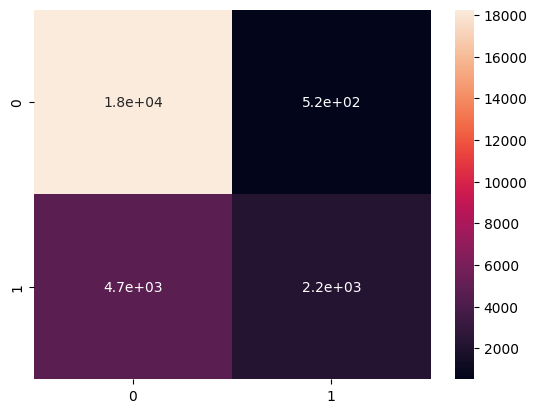

In [3]:
original_cm = metrics.confusion_matrix(test_anon_bool, model.predict(test_features))
sns.heatmap(original_cm, annot=True)

In [4]:
metrics.f1_score(model.predict(test_features),test_anon_bool)

0.4540720683191002

In [5]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 300, 500, 1000],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2]  # Step size shrinkage
}


In [6]:
search = GridSearchCV(model, param_grid=param_grid, cv=2, scoring="f1", n_jobs=-1)
search.fit(val_features, val_anon_bool)


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'n_estimators': [100, 300, 500, 1000]},
             scoring='f1')

In [11]:
cvgs_results = pd.DataFrame(search.cv_results_)
display(cvgs_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,158.435803,0.602502,0.019482,0.005286,0.01,100,"{'learning_rate': 0.01, 'n_estimators': 100}",0.309278,0.270833,0.290056,0.019223,16
1,471.684873,0.332610,0.029702,0.000505,0.01,300,"{'learning_rate': 0.01, 'n_estimators': 300}",0.559322,0.589532,0.574427,0.015105,15
2,808.876536,20.309863,0.054856,0.008626,0.01,500,"{'learning_rate': 0.01, 'n_estimators': 500}",0.638522,0.658031,0.648277,0.009754,14
3,1588.213742,9.315773,0.150089,0.008987,0.01,1000,"{'learning_rate': 0.01, 'n_estimators': 1000}",0.693671,0.714286,0.703978,0.010307,12
4,157.304381,0.684735,0.023383,0.006355,0.05,100,"{'learning_rate': 0.05, 'n_estimators': 100}",0.634667,0.664962,0.649814,0.015147,13
5,474.911527,0.359409,0.026758,0.002157,0.05,300,"{'learning_rate': 0.05, 'n_estimators': 300}",0.707071,0.764846,0.735958,0.028887,10
6,810.420130,4.380937,0.053709,0.005731,0.05,500,"{'learning_rate': 0.05, 'n_estimators': 500}",0.769231,0.767059,0.768145,0.001086,7
7,1611.834741,7.562440,0.075313,0.002520,0.05,1000,"{'learning_rate': 0.05, 'n_estimators': 1000}",0.806527,0.777778,0.792152,0.014375,3
8,164.998429,0.321718,0.029505,0.010815,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.707921,0.737349,0.722635,0.014714,11
9,491.527941,0.301794,0.036839,0.004156,0.1,300,"{'learning_rate': 0.1, 'n_estimators': 300}",0.761446,0.769953,0.765699,0.004254,8


In [8]:
model_optimised = GradientBoostingClassifier(**search.best_params_)
model_optimised.fit(train_features, train_anon_bool)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=1000)

In [9]:
print("Optimised Model Accuracy:", model_optimised.score(test_features, test_anon_bool))
print("Optimised Model F1 Score:", metrics.f1_score(test_anon_bool, model_optimised.predict(test_features)))

Optimised Model Accuracy: 0.8174133229450721
Optimised Model F1 Score: 0.5531509200114406


Text(0.5, 1.0, 'Static R3D-CNN with Gradient Boosting Classifier')

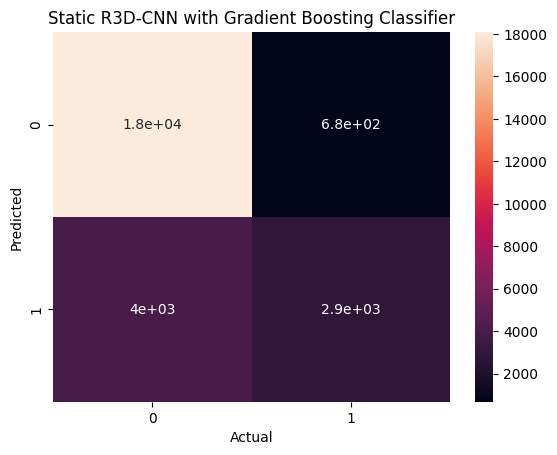

In [12]:
optimised_cm = metrics.confusion_matrix(test_anon_bool, model_optimised.predict(test_features))
sns.heatmap(optimised_cm, annot=True)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Static R3D-CNN with Gradient Boosting Classifier")